# Stereo Matching with Pytorch

## **Part 2: Learning based stereo matching**
      
(1) Train            
(2) Modifying different parameters for better performance           
(3) Evaluate stereo matching

Rather than of using SSD/SAD to compute a matching cost for the disparity map, in this part we will train a network to directly learn that from the data instead. We will implement what has been proposed in the paper [[Zbontar & LeCun, 2015]](https://arxiv.org/abs/1409.4326) and see how it performs compare to classical cost matching approaches.

**Note:**
This notebook is intendend to be run on [Google Colab](https://colab.research.google.com). So first upload the notebook to Google Colab, and then select "GPU" in the menu "Runtime" -> "Change runtime time" -> "Hardward accelerator".

## Setup 

Here we will download neccessary data and set up the environment. You can skip this if the data files is still in your colab environment.

In [1]:
import os
cwd = os.getcwd()

if os.path.basename(cwd) == 'proj4_code':
    os.chdir(os.path.dirname(cwd))

print(os.getcwd())
    
'''
# Comment if run locally
# # download and extract the data -- training data
!rm Middlebury_data.zip
!wget "https://onedrive.live.com/download?cid=21FDB23F3688A415&resid=21FDB23F3688A415%2140534&authkey=AJX_HsPo6T6wJV8" -O Middlebury_data.zip && unzip Middlebury_data.zip

# # download and extract the data for the appropriate window size -- pre-trained network
!rm mc_cnn_network_pretrain_*

!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21121&authkey=AIoYwMTUWB7ekgE" -O mc_cnn_network_pretrain_ws11.pth
!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21119&authkey=AGjnpMZXwihXW_8" -O mc_cnn_network_pretrain_ws5.pth 
!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21120&authkey=AE_5NGf-Qk13YJ0" -O mc_cnn_network_pretrain_ws9.pth 
!wget "https://onedrive.live.com/downloaD?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21122&authkey=AO9QfmLdbpp2cyA" -O mc_cnn_network_pretrain_ws15.pth
'''

C:\Users\prana\OneDrive\Desktop\CS6476\computerVision\proj4


'\n# Comment if run locally\n# # download and extract the data -- training data\n!rm Middlebury_data.zip\n!wget "https://onedrive.live.com/download?cid=21FDB23F3688A415&resid=21FDB23F3688A415%2140534&authkey=AJX_HsPo6T6wJV8" -O Middlebury_data.zip && unzip Middlebury_data.zip\n\n# # download and extract the data for the appropriate window size -- pre-trained network\n!rm mc_cnn_network_pretrain_*\n\n!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21121&authkey=AIoYwMTUWB7ekgE" -O mc_cnn_network_pretrain_ws11.pth\n!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21119&authkey=AGjnpMZXwihXW_8" -O mc_cnn_network_pretrain_ws5.pth \n!wget "https://onedrive.live.com/download?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21120&authkey=AE_5NGf-Qk13YJ0" -O mc_cnn_network_pretrain_ws9.pth \n!wget "https://onedrive.live.com/downloaD?cid=D9AE7CB176DB9D55&resid=D9AE7CB176DB9D55%21122&authkey=AO9QfmLdbpp2cyA" -O mc_cnn_network_

## Compute Requirements

You can try out Google Colab to run this notebook. These are the steps we follow:
1. Upload this notebook to google colab
2. Zip the folders ```proj4_code```, `proj4_unit_tests` and `semiglobalmatching` in the project directory and upload it to the colab runtime
3. Unzip the uploaded zip using ```!unzip -qq <uploaded_file>.zip -d ./```

Remember to download all the files saved and changes to code you made on the colab.

In [2]:
'''
# Comment if run locally
!unzip -qq proj4.zip -d ./

# delete folder
# !rm -r proj4_code
# !rm proj4_code.zip
'''

'\n# Comment if run locally\n!unzip -qq proj4.zip -d ./\n\n# delete folder\n# !rm -r proj4_code\n# !rm proj4_code.zip\n'

In [4]:
# import torch and set tensor type
import torch
%matplotlib inline
import matplotlib.pyplot as plt

use_cuda = True and torch.cuda.is_available()
print("use_cuda:", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

torch.backends.cudnn.deterministic = True
torch.manual_seed(333) # do not change this, this is to ensure your result is reproducible

use_cuda: True


Run this cell to be able to reload any changes you make to your code on the fly.

You can access your source code in the left-hand side menu under the folder icon. You can use the built-in editing tools to fix any bugs right here in colab.

In [5]:
%load_ext autoreload
%autoreload 2

## DataLoader

We have already stored all the training data in the `.npy` format, now we just need to simply load them up.

In [6]:
# load up all data for training and testing
from proj4_code.dataset import loadbin, DataLoader
import numpy as np
import os
import random

data_dir = 'Middlebury_data'

# the img to show
ind_img = "Bicycle1"

# pick another 4 images for testing
test_scenes = [ind_img]
test_scenes += ["Adirondack", "Flowers", "Playroom", "Recycle"]

# pick the left for training
train_scenes = [
    "Playtable",
    "Shelves",
    "Vintage",
    "Backpack",
    "Cable",
    "Classroom1",
    "Couch",
    "Mask",
    "Shopvac",
    "Sticks",
    "Storage",
    "Sword1",
    "Sword2",
    "Umbrella",
]

val_scenes = ["Jadeplant", "Motorcycle", "Piano", "Pipes"]

print(os.getcwd())

print(os.path.isdir('Middlebury_data'))

TrainData = DataLoader(data_dir, train_scenes, ws=11)
TestData = DataLoader(data_dir, test_scenes, ws=11, num_batches_per_epoch=20)
ValData = DataLoader(data_dir, val_scenes, ws=11, num_batches_per_epoch=20)

C:\Users\prana\OneDrive\Desktop\CS6476\computerVision\proj4
True


### Visualizing the Data
Let's visualize an example from the test set. We'll be visualising the disparity maps we compute for this image later on.*italicized text*

Left Image


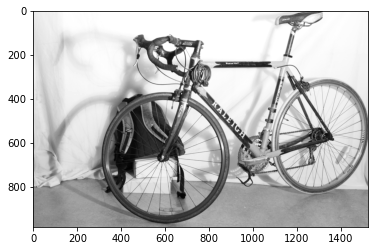

Right Image


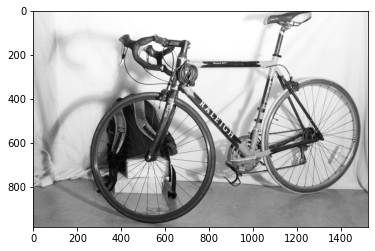

Ground Truth disparity


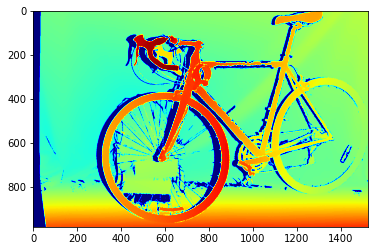

In [7]:
# visualize the test data
print('Left Image')
plt.imshow(TestData.imgs_left[ind_img][0].cpu().numpy(),cmap="gray")
plt.show()
print('Right Image')
plt.imshow(TestData.imgs_right[ind_img][0].cpu().numpy(),cmap="gray")
plt.show()
print('Ground Truth disparity')
plt.imshow(TestData.disps[ind_img], cmap='jet')
plt.show()

## Train MCNET

Train the network that learn how to classify 2 patches as positive vs negative match by experimenting with the learning parameters.

The training process works as follows:

1. In every iteration, we find non-zero disparity values and sample patches around a random selection of those pixels with `gen_patch`.
2. We construct positive and negative examples for those patches by correctly shifting the right image in the positive sample, and incorrectly shifting it with some random jitter within some bound.
3. We collate these positive and negative examples into a batch, and pass that to the model.
4. We evaluate the loss, and backpropagate the changes to adjust the model's weights.
5. An epoch is an iteration over a number of batches of these samples. Each epoch is large enough to cover a representative sample of the dataset, but does not cover the entire dataset due to time-constraints.

In [8]:
from proj4_code.utils import save_model, load_model
from proj4_code.part2a_network import MCNET

In [9]:
from proj4_code.train import Trainer

## Changing hyperparameters

The block below allows you to set up your model before the training commences.

You can use this to set the values for your hyperparameters.

Run the notebook once without changing the settings, and then try some different ones out.

### Vary window size

Experiment with different window size, namely 5x5, 9x9, 11x11 and 15x15 and compare the performance. You can set this in the code block below for training.

In [10]:
############# EXPERIMENT WITH THESE ########
######################################################################
# You can also train from scratch by setting load_path to None
#######################################################################

######STUDENT CODE HERE##########
# you can change this to load up pretrain network for other window size
# pick your favorite window size (from the pretrained sizes available)
ws = 11 
batch_size = 128
#################################

net_train = MCNET(ws=ws,load_path = f"mc_cnn_network_pretrain_ws{ws}.pth",strict=True, batch_size=batch_size)
# net_train = MCNET(ws=11,load_path = None,strict=True, batch_size=batch_size) 

max_epoch = 50
learning_rate = 0.0001
optimizer = torch.optim.Adam(net_train.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(net_train.net.parameters(), lr=learning_rate, momentum=0.9) # Uncomment this to use the SGD optimizer

############################################
# generate train dataloader and test dataloader
TrainData = DataLoader(data_dir, train_scenes, ws=ws, batch_size=batch_size, num_batches_per_epoch=512)
TestData = DataLoader(data_dir, test_scenes, ws=ws, batch_size=batch_size, num_batches_per_epoch=8)
ValData = DataLoader(data_dir, val_scenes, ws=ws, batch_size=batch_size,  num_batches_per_epoch=8)

## Start Training!

Now that you have set up your model, you can start training it. It might take you 20-30 minutes to complete the training.

You can use the `resume_training` option if you interrupt your training, and Colab hasn't reset your runtime and deleted the files.

In [14]:
# train
import math
import time
import random
st = time.time()

viz_frequency = 5
save_frequency = 10 #for saving model

#########################################################################################
# In case training is interrupted, 
# change the `resume_training` flag to True.
#
# Make sure to have the model weights file (e.g. mc_cnn_network_ws11.pth)
# and the checkpoint file (e.g. train_checkpoint_mc_cnn_ws11.pth) in the same folder
trainer = Trainer(model=net_train,
                       dataloader=TrainData,
                       batch_size=batch_size, 
                       ws=ws, 
                       max_epoch=max_epoch,
                       optimizer=optimizer,
                       viz_frequency=viz_frequency, 
                       save_frequency=save_frequency,
                       fname = f'mc_cnn_network_ws{ws}.pth',
                       resume_training=False,
                       checkpoint_path=f"train_checkpoint_mc_cnn_ws{ws}.pth")

train_loss_history, train_acc_history, val_loss_history, val_acc_history = trainer.train(ValData)
print('Time elasped: ', time.time() - st)

Time elapsed: 3.00min 3.09s,  Iteration: 1/50, Train Loss: 0.6931, Train accuracy: 0.50, Val loss:0.6931, Val accuracy: 0.50
Time elapsed: 18.00min 26.87s,  Iteration: 6/50, Train Loss: 0.6931, Train accuracy: 0.50, Val loss:0.6931, Val accuracy: 0.50


KeyboardInterrupt: 

The network will be saved in `mc_cnn_network_vanilla.pth` or whatever name you set, this is the final saved model you'll need to run other part of the project. You can download a copy of this from colab so that you don't lost progress if anything goes wrong.

Experiment with different network parameters(window size, optimizer type, etc.) and answer the reflection questions in the report.


### Visualize training curves

Let's take a look at the training and validation losses and accuracy



In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(5*4)
ax1.plot(train_loss_history, label="train loss")
ax1.plot(val_loss_history, label="val loss")
ax1.set_title("Loss Plot")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(train_acc_history, label="train accuracy")
ax2.plot(val_acc_history, label="val accuracy")
ax2.legend()
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_title("Accuracy Plot")
plt.show()

## Evaluate stereo matching

Now that we have a trained model ready, let's visualize some results!

Our eventual goal is to generate the disparity maps using our matching-cost network.

The next few cells will guide you through this process.

In [ ]:
###########Change to your best model here################

net_test = MCNET(batch_size = 1, load_path = f'mc_cnn_network_ws{ws}.pth')

############################################

In [ ]:
try:
  from proj4_code.part1b_similarity_measures import sad_similarity_measure,ssd_similarity_measure
  from proj4_code.part1c_disparity_map import calculate_disparity_map
  from proj4_code.part2c_disparity import calculate_mccnn_disparity_map, mc_cnn_similarity
except ModuleNotFoundError:
  print('\033[91m Error: please upload disparity_map.py and similarity_measures.py from part 1\033[0m ')
from proj4_code.dataset import loadbin, DataLoader
import numpy as np
import os
import time
    
scale = 5
im_left = TestData.imgs_left[ind_img][0][::scale,::scale]
im_right = TestData.imgs_right[ind_img][0][::scale,::scale]
im_dispnoc = TestData.disps[ind_img][::scale,::scale]
im_dispnoc_full = TestData.disps[ind_img]

### Visualizing the ground-truth

Once again, let's take a look at the ground-truth images, and the best-case disparity map that can be generated

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(5*3)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ax3.imshow(im_dispnoc/scale, cmap="jet")
ax3.title.set_text('Ground Truth disparity')

## Extract network components

The feature extractor (convolutional layers) and the classifier (the fully-connected layers) are both independently useful parts of the network.

Let's extract them from our network so we can use them independently

In [ ]:
# Get the feature extractor and fully-connected layers from trained model 
feature_extractor = net_test.conv
fc_layers = net_test.classifier

### Extract Conv Features

We use the feature extractor to extract convolutional features from the left and right images.

In [ ]:
# Extract CNN features from left and right images
with torch.no_grad(): # Don't need to compute gradients here
  cnn_left_img = feature_extractor(im_left.cuda().unsqueeze(0).unsqueeze(0))
  cnn_right_img = feature_extractor(im_right.cuda().unsqueeze(0).unsqueeze(0))

# Visualizing the error profile of our trained network

Let's extract a patch, and a window to search from the left and right images.

We'll then use these to analyse the error profiles of our trained network, and compare them to the error profile from the SAD and SSD metrics.

### 1. Extract and visualize the patches

The cell below will extract an "interesting" patch for us to analyze the error profile for, and visualize it.

In [ ]:
# extract a patch of interest from the left image, and it's CNN features
patch_left_img = im_left[80:91, 85:96]
cnn_patch_left_img = cnn_left_img[...,80:91, 85:96]

# get the search area in the right image
search_area_right_img = im_right[80:91, 60:102]
cnn_search_area_right_img = cnn_right_img[...,80:91, 60:102]


plt.imshow(patch_left_img.cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(search_area_right_img.cpu().numpy(),cmap='gray')
plt.show()

### Visualizing the error profiles
Now that we have the patches, we can use our similarity measures, one from SAD, one from SSD, and the final one from the MC-CNN using the convolutional features of the patches we extracted.

**Note:** Your error profile might come out non-convex, in which case your network has learned poorly. Due to the stochastic nature of neural networks, and this specific algorithm, you aren't guaranteed to get a great profile. Please try training the network again to make sure you have a convex error profile with the minimum error somewhere between index 10 and 20

In [ ]:
fig = plt.figure(figsize=(18,3))

similarity_vals = np.array([sad_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-10)])
plt.subplot(1, 3, 1)
plt.plot(similarity_vals)
plt.title('SSD')

similarity_vals = np.array([ssd_similarity_measure(patch_left_img, search_area_right_img[:,h_idx:(h_idx+11)]) for h_idx in range(search_area_right_img.shape[1]-10)])
plt.subplot(1, 3, 2)
plt.plot(similarity_vals)
plt.title('SAD')

similarity_vals = mc_cnn_similarity(fc_layers,
                                    cnn_patch_left_img,
                                    torch.cat([
                                      cnn_search_area_right_img[...,h_idx:(h_idx+11)]
                                      for h_idx in range(search_area_right_img.shape[1]-10)],
                                      dim=0)).cpu().numpy()
plt.subplot(1, 3, 3)
plt.plot(similarity_vals)
plt.title('MC-CNN')
fig.suptitle('Matching cost comparison')
plt.show()

# Calculate the Disparity map

We calculate the disparity map using the functions you implemented in part1, as well as the `calculate_mc_cnn_disparity_map` function from `part2c_disparity`.

**Note:**

**PLEASE** ensure that your method is efficient, as this is a long process, and will take a few minutes at the very least. A careless (and inefficient) implementation can take _hours_ to run which will be frustrating.

In [ ]:
#calculate the disparity map with block size of 11, this will take a while
st = time.time()
disp_map = calculate_disparity_map((im_left.unsqueeze(0).transpose(2,0).transpose(0,1)), #swap the channel
                                   (im_right.unsqueeze(0).transpose(2,0).transpose(0,1)), 
                                   block_size=11, 
                                   sim_measure_function = sad_similarity_measure,
                                   max_search_bound = 30)
print('Time Elasped for sad_similarity_measure:', time.time() - st)

st = time.time()
disp_map_cnn = calculate_mccnn_disparity_map(net_test,
                                             im_left.unsqueeze(0),
                                             im_right.unsqueeze(0),
                                             block_size = 11,
                                             sim_measure_function = mc_cnn_similarity,
                                             max_search_bound = 30)
print('Time Elasped for cnn_similarity_measure:', time.time() - st)

# Visualize & evaluate disparity maps

Now that we've generated our disparity maps, let's see what they look like.

We'll also evaluate the performance of the SAD and MC-CNN generated disparity maps with some metrics.

1. _Average error (`avgerr`):_ This gives the average difference between the disparity map and the ground-truth.

2. _1px disparity error rate (`bad1`):_ The percentage of pixels that have a disparity error of more than 1 pixel.

3. _2px disparity error rate (`bad2`):_ The percentage of pixels that have a disparity error of more than 2 pixels.

4. _4px disparity error rate (`bad4`):_ The percentage of pixels that have a disparity error of more than 4 pixels.

In [ ]:
from proj4_code.utils import evaluate_stereo

In [ ]:
from matplotlib.colors import Normalize

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(5*3)

ax1.imshow(im_left.cpu().numpy(), cmap="gray")
ax1.title.set_text('Left image')

ax2.imshow(im_right.cpu().numpy(), cmap="gray")
ax2.title.set_text('Right image')

ratio = scale

vmin = (im_dispnoc/ratio).min()
vmax = (im_dispnoc/ratio).max()
colornorm = Normalize(vmin=vmin, vmax=vmax)

ax3.imshow(im_dispnoc/ratio, cmap="jet", interpolation='nearest', norm=colornorm)
ax3.title.set_text('Ground Truth disparity')
fig, (ax4, ax5) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(5*2)

ax4.imshow((disp_map.cpu().numpy()), cmap='jet', interpolation='nearest', norm=colornorm)
ax4.title.set_text('SAD Disparity map')

ax5.imshow((disp_map_cnn.cpu().numpy().astype(np.float32)), cmap='jet', interpolation='nearest', norm=colornorm)
ax5.title.set_text('MCCNN Disparity map')

plt.show()

cnn_avgerr, cnn_bad1, cnn_bad2, cnn_bad4 = evaluate_stereo(im_dispnoc_full,
                                                           disp_map_cnn.cpu().numpy().astype(np.float32))
sad_avgerr,  sad_bad1, sad_bad2, sad_bad4 = evaluate_stereo(im_dispnoc_full,
                                                            disp_map.cpu().numpy().astype(np.float32))

print('--------------------------------------------------------------------------')
print('Metrics: \t\t', 'SAD','\t\t\t','MCCNN')
print('--------------------------------------------------------------------------')
print('Average Error \t\t',sad_avgerr,'\t\t', cnn_avgerr)
print('%error > 1 pixel\t', sad_bad1,'\t',cnn_bad1)
print('%error > 2 pixels\t',sad_bad2, '\t',cnn_bad2)
print('%error > 4 pixels\t',sad_bad4, '\t', cnn_bad4)

# Semiglobal Matching

Now that we've obtained our disparity maps, let's try to improve our performance using semiglobalmatching as we did in part1


Run the cell below to compute the disparity maps again, this time with semiglobal matching.

In [ ]:
from semiglobalmatching.sgm import sgm_mccnn, sgm
from proj4_code.part2c_disparity import calculate_mccnn_cost_volume, mc_cnn_similarity

In [ ]:
ws = net_test.ws
st = time.time()
sgm_disparity_map = sgm(im_left.cpu().numpy(),
                        im_right.cpu().numpy(),
                        "result",
                        max_search_bound=30,
                        sim_fn=sad_similarity_measure,
                        block_size=ws)
print('Time Elasped for sgm_sad_similarity_measure:', time.time() - st)


ax1.imshow((sgm_disparity_map.astype(np.float32)), cmap='jet', interpolation='nearest')


st = time.time()
# The window size should be the window size of the model you're evaluating
cost_volume_mccnn = calculate_mccnn_cost_volume(net_test,
                                                im_left.unsqueeze(0),
                                                im_right.unsqueeze(0),
                                                block_size=ws,
                                                sim_measure_function=mc_cnn_similarity)
sgm_disp_map_cnn = sgm_mccnn(cost_volume_mccnn.cpu().numpy(),
                             "result",
                             max_search_bound=30,
                             sim_fn=mc_cnn_similarity,
                             block_size=9)
print('Time Elasped for sgm_cnn_similarity_measure:', time.time() - st)

### Visualize SGM disparity maps

Let's visualise the disparity maps created by SGM, and see their scores.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(5*2)

vmin = (im_dispnoc_full/scale).min()
vmax = (im_dispnoc_full/scale).max()
colornorm = Normalize(vmin=vmin, vmax=vmax)

ax1.imshow((sgm_disparity_map.astype(np.float32)),
           cmap='jet',
           interpolation='nearest',
           norm=colornorm)
ax2.imshow((sgm_disp_map_cnn.astype(np.float32)),
           cmap='jet',
           interpolation='nearest',
           norm=colornorm)
plt.show()


sad_avgerr,  sad_bad1, sad_bad2, sad_bad4 = evaluate_stereo(im_dispnoc_full,
                                                            sgm_disparity_map.astype(np.float32))
cnn_avgerr, cnn_bad1, cnn_bad2, cnn_bad4 = evaluate_stereo(im_dispnoc_full,
                                                           sgm_disp_map_cnn.astype(np.float32))
print('--------------------------------------------------------------------------')
print('Metrics: \t\t', 'SAD+SGM','\t\t\t','MCCNN+SGM')
print('--------------------------------------------------------------------------')
print('Average Error \t\t',sad_avgerr,'\t\t', cnn_avgerr)
print('%error > 1 pixel\t', sad_bad1,'\t',cnn_bad1)
print('%error > 2 pixels\t',sad_bad2, '\t',cnn_bad2)
print('%error > 4 pixels\t',sad_bad4, '\t', cnn_bad4)

# Save model for grading (IMPORTANT)

Once you're satisfied with your performance of the models, you can run the code below to save your model in the format we require to evaluate it on Gradescope.

You should obtain a file called `final_model_data.pth`

Save this model to your `proj4_code` folder, and include it in your submission zip. Currently, it is still on Google's servers, and you will not be able to access it once the session is shut. You can click on the folder icon to the left, find `final_model_data.pth`, and download it. Copy it to your proj4_code folder while submitting to gradescope.

Gradescope will evaluate your model on a held-out example, and score you based on the stereo metrics and the classification accuracy you obtain.

A reasonably trained model can achieve full points, so try uploading it once, even if you aren't 100% satisfied with your visualisations.

In [ ]:
from proj4_code.utils import save_model_for_evaluation

In [ ]:
save_model_for_evaluation(net_test)